In [ ]:
import os
import sys

def is_colab():
    return 'google.colab' in sys.modules

if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_PATH = '/content/drive/MyDrive/MEC_Stackelberg_Project'
else:
    # 自动根据当前脚本定位项目根路径
    PROJECT_PATH = os.path.abspath(os.path.join(os.path.dirname(__file__), '..')) \
        if '__file__' in globals() else os.path.abspath(os.path.join(os.getcwd(), '..'))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

print(f"项目路径设置为: {PROJECT_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
项目路径设置为: /content/drive/MyDrive/MEC_Stackelberg_Project


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

import src.models as models
import src.config as config
import src.run_experiment as run_experiment
import src.utils as utils
import src.algorithms.Stackelberg_solver as stackelberg_solver
import src.algorithms.user_game_solver as user_game_solver
import src.algorithms.baseline_solver as baseline_solver
import src.algorithms.previous_work as previous_work

SEED = 43

In [8]:
SWEEPER_PATH = os.path.join(PROJECT_PATH, "configs", "sweep_num_user.json")
sweeper = run_experiment.ParamSweeper(SWEEPER_PATH)
configs = sweeper.sweep_configs()
print(configs)

sweep_user_provider = []
for i,config in enumerate(configs):
  users = run_experiment.create_users(config,SEED,True)
  provider = run_experiment.create_provider(config)
  sweep_user_provider.append((users,provider))

[<src.config.Config object at 0x7ef50687b890>, <src.config.Config object at 0x7ef504fc31d0>, <src.config.Config object at 0x7ef50521a5d0>, <src.config.Config object at 0x7ef4fb70af10>, <src.config.Config object at 0x7ef4fb708f90>]


In [9]:
tu, tp = sweep_user_provider[0][0], sweep_user_provider[0][1]
for u in tu:
    print(u.user_id)
    u.print_user()
tp.print_providers()

0
 task: d= 0.7301091327795579  b= 51.852790828122664  alpha= 10.666954820929941
 local cpu= 1.1013962436640183
 S_i= 29.35127707894157
1
 task: d= 1.8321804261960515  b= 46.963679284405075  alpha= 10.145069122121802
 local cpu= 1.0614329830400666
 S_i= 31.75781288118785
2
 task: d= 1.0088422517197586  b= 12.09571543888293  alpha= 14.333243204496
 local cpu= 0.7212675297127461
 S_i= 29.372148451780856
3
 task: d= 0.6533253999928945  b= 68.71217798453873  alpha= 14.244695738724307
 local cpu= 1.1681416875760657
 S_i= 33.16507846717124
4
 task: d= 1.3915167216794377  b= 56.220174923970156  alpha= 10.412500248485777
 local cpu= 0.683613375817467
 S_i= 32.33279042202989
5
 task: d= 0.5102590981289139  b= 47.11058110018923  alpha= 12.377981835036266
 local cpu= 1.1360639304817615
 S_i= 32.21902523846965
6
 task: d= 2.320306151560313  b= 45.81840831971447  alpha= 10.520094749273815
 local cpu= 0.788367088370451
 S_i= 29.849340761904873
7
 task: d= 2.2300342412143634  b= 56.39676412228468  al

In [9]:
"""
jiadi liu epf Sweep
"""
sweep_results_epf = []
sweep_param = sweeper.vary_param
sweep_values = sweeper.values
for i,up in enumerate(sweep_user_provider):
  users, provider = up[0], up[1]
  pe_epf, pn_epf, X_epf, U_epf, results_epf = previous_work.epf_baseline(users,provider,initial_p_E=provider.c_E+0.1,initial_p_N=provider.c_N+0.1)
  sp_info={
      "X": list(X_epf),
      "U_X": U_epf,
      "p_E": pe_epf,
      "p_N": pn_epf,
      "f_max": provider.f_max,
      "B_max": provider.B_max,
      "c_E": provider.c_E,
      "c_N": provider.c_N
  }
  of, ob, oc = models.ora_solver([u for u in users if u.user_id in X_epf], provider, pe_epf, pn_epf)
  user_game_info = {
      "f": list(of),
      "b": list(ob),
      "sum_offload_cost": oc,
      "social_cost": oc+np.sum([u.cost_local() for u in users if u.user_id not in X_epf]),
      "sum_f": np.sum(of),
      "sum_b": np.sum(ob),
      "f_utilization": np.sum(of)/provider.f_max,
      "b_utilization": np.sum(ob)/provider.B_max
  }
  user_info = [u.log_info(pe_epf, pn_epf) for u in users]
  res={
      "sweep_param": sweep_param,
      "sweep_value": sweep_values[i],
      "sp_info": sp_info,
      "user_game_info": user_game_info,
      "user_info": user_info
  }
  sweep_results_epf.append(res)

EPF_LOG_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_epf.log")
EPF_JSON_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_epf.json")

utils.log_sweep_experiments_results(sweep_results_epf, EPF_LOG_PATH)
with open(EPF_JSON_PATH, "w", encoding="utf-8") as f:
    json.dump(sweep_results_epf, f, ensure_ascii=False, indent=2)

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:498: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
2025-04-04 03:53:20,830 - INFO - ===== Sweep Experiments Results =====
INFO:sweeper_logger:===== Sweep Experiments Results =====
2025-04-04 03:53:20,833 - INFO - ===== Experiment 1 =====
INFO:sweeper_logger:===== Experiment 1 =====
2025-04-04 03:53:20,836 - INFO - ----- Single Experiment Result -----
INFO:sweeper_logger:----- Single Experiment Result -----
2025-04-04 03:53:20,839 - INFO - Sweep Paramet

In [ ]:
"""
Tutuncuoglu Sweep
"""
sweep_results_tu = []
sweep_param = sweeper.vary_param
sweep_values = sweeper.values
for i,up in enumerate(sweep_user_provider):
  users, provider = up[0], up[1]
  X_tu, U_tu, p_tu, results_tu = previous_work.tutuncuoglu_exhaustive_search(users,provider)
  sp_info={
      "X": list(X_tu),
      "U_X": U_tu,
      "p": p_tu,
      "f_max": provider.f_max,
      "B_max": provider.B_max,
      "c_E": provider.c_E,
      "c_N": provider.c_N
  }
  best_result_tt = next((r for r in results_tu if r["X"] == X_tu), None)
  sum_f_tt, sum_b_tt = best_result_tt["sum_f"], best_result_tt["sum_b"]
  f, b = best_result_tt["f"], best_result_tt["b"]
  user_game_info = {
      "f": list(f),
      "b": list(b),
      "sum_offload_cost": np.sum([u.cost_local() for u in users if u.user_id in X_tu]),
      "social_cost": np.sum([u.cost_local() for u in users]),
      "sum_f": sum_f_tt,
      "sum_b": sum_b_tt,
      "f_utilization": sum_f_tt/provider.f_max,
      "b_utilization": sum_b_tt/provider.B_max
  }
  user_info = [u.log_info(pe_epf, pn_epf) for u in users]
  res={
      "sweep_param": sweep_param,
      "sweep_value": sweep_values[i],
      "sp_info": sp_info,
      "user_game_info": user_game_info,
      "user_info": user_info
  }
  sweep_results_tu.append(res)

TU_LOG_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_tu.log")
TU_JSON_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_tu.json")

utils.log_sweep_experiments_results(sweep_results_tu, TU_LOG_PATH)
with open(TU_JSON_PATH, "w", encoding="utf-8") as f:
    json.dump(sweep_results_tu, f, ensure_ascii=False, indent=2)

In [5]:
"""
Branch and Bound Sweep
"""
sweep_results_bnb = []
sweep_param = sweeper.vary_param
sweep_values = sweeper.values
for i,up in enumerate(sweep_user_provider):
  users, provider = up[0], up[1]
  pe_bnb, pn_bnb, X_bnb, U_bnb, results_bnb = stackelberg_solver.branch_and_bound(users,provider)
  sp_info={
      "X": list(X_bnb),
      "U_X": U_bnb,
      "p_E": pe_bnb,
      "p_N": pn_bnb,
      "f_max": provider.f_max,
      "B_max": provider.B_max,
      "c_E": provider.c_E,
      "c_N": provider.c_N
  }
  of, ob, oc = models.ora_solver([u for u in users if u.user_id in X_bnb], provider, pe_bnb, pn_bnb)
  user_game_info = {
      "f": list(of),
      "b": list(ob),
      "sum_offload_cost": oc,
      "social_cost": oc+np.sum([u.cost_local() for u in users if u.user_id not in X_bnb]),
      "sum_f": np.sum(of),
      "sum_b": np.sum(ob),
      "f_utilization": np.sum(of)/provider.f_max,
      "b_utilization": np.sum(ob)/provider.B_max
  }
  user_info = [u.log_info(pe_bnb, pn_bnb) for u in users]
  res={
      "sweep_param": sweep_param,
      "sweep_value": sweep_values[i],
      "sp_info": sp_info,
      "user_game_info": user_game_info,
      "user_info": user_info
  }
  sweep_results_bnb.append(res)

BNB_LOG_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_bnb.log")
BNB_JSON_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_bnb.json")

utils.log_sweep_experiments_results(sweep_results_bnb, BNB_LOG_PATH)
with open(BNB_JSON_PATH, "w", encoding="utf-8") as f:
    json.dump(sweep_results_bnb, f, ensure_ascii=False, indent=2)

X_init= {1, 3}


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:498: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible


/content/drive/MyDrive/MEC_Stackelberg_Project/src/models.py:86: RuntimeWarning: invalid value encountered in sqrt
  f_thresh = ((C_l_i - C_hat_eb_i) - np.sqrt((C_l_i - C_hat_eb_i)**2 - C_hat_ef_i**2)) / (2*p_E)
/content/drive/MyDrive/MEC_Stackelberg_Project/src/models.py:93: RuntimeWarning: invalid value encountered in sqrt
  B_thresh = ((C_l_i - C_hat_ef_i) - np.sqrt((C_l_i - C_hat_ef_i)**2 - C_hat_eb_i**2)) / (2*p_N)


X_init= {0, 1, 2, 3, 4, 11, 12}
X_init= {0, 2, 5, 8, 10, 13, 14, 18}
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization

2025-04-04 01:48:14,645 - INFO - ===== Sweep Experiments Results =====
INFO:sweeper_logger:===== Sweep Experiments Results =====
2025-04-04 01:48:14,648 - INFO - ===== Experiment 1 =====
INFO:sweeper_logger:===== Experiment 1 =====
2025-04-04 01:48:14,652 - INFO - ----- Single Experiment Result -----
INFO:sweeper_logger:----- Single Experiment Result -----
2025-04-04 01:48:14,654 - INFO - Sweep Parameter: num_users
INFO:sweeper_logger:Sweep Parameter: num_users
2025-04-04 01:48:14,656 - INFO - SP Info:
{
  "X": [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    9
  ],
  "U_X": 67.83447442019266,
  "p_E": 2.1032305149,
  "p_N": 0.4031845879,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.01,
  "c_N": 0.01
}
INFO:sweeper_logger:SP Info:
{
  "X": [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    9
  ],
  "U_X": 67.83447442019266,
  "p_E": 2.1032305149,
  "p_N": 0.4031845879,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.01,
  "c_N": 0.01
}
2025-04-04 01:48:14,658 - INFO - User Game Info:


In [ ]:
"""
Random Sweep
"""
sweep_results_random = []
sweep_param = sweeper.vary_param
sweep_values = sweeper.values
for i,up in enumerate(sweep_user_provider):
  users, provider = up[0], up[1]
  X_rand, p_rand, U_rand, results_rand = baseline_solver.random_offloader_baseline(users, provider, 10)
  sp_info={
      "X": list(X_rand),
      "U_X": U_rand,
      "p_E": p_rand[0],
      "p_N": p_rand[1],
      "f_max": provider.f_max,
      "B_max": provider.B_max,
      "c_E": provider.c_E,
      "c_N": provider.c_N
  }
  of, ob, oc = models.ora_solver([u for u in users if u.user_id in X_rand], provider, p_rand[0], p_rand[1])
  user_game_info = {
      "f": list(of),
      "b": list(ob),
      "sum_offload_cost": oc,
      "social_cost": oc+np.sum([u.cost_local() for u in users if u.user_id not in X_oracle]),
      "sum_f": np.sum(of),
      "sum_b": np.sum(ob),
      "f_utilization": np.sum(of)/provider.f_max,
      "b_utilization": np.sum(ob)/provider.B_max
  }
  user_info = [u.log_info(pe_oracle, pn_oracle) for u in users]
  res={
      "sweep_param": sweep_param,
      "sweep_value": sweep_values[i],
      "sp_info": sp_info,
      "user_game_info": user_game_info,
      "user_info": user_info
  }
  sweep_results_random.append(res)

RAND_LOG_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_rand.log")
RAND_JSON_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_rand.json")

utils.log_sweep_experiments_results(sweep_results_random, RAND_LOG_PATH)
with open(RAND_JSON_PATH, "w", encoding="utf-8") as f:
    json.dump(sweep_results_random, f, ensure_ascii=False, indent=2)

In [6]:
"""
Oracle Sweep
"""
sweep_results_oracle = []
sweep_param = sweeper.vary_param
sweep_values = sweeper.values
for i,up in enumerate(sweep_user_provider):
  users, provider = up[0], up[1]
  pe_oracle, pn_oracle, X_oracle, U_oracle, results_oracle = baseline_solver.oracle_baseline_greedy(users, provider, (0.01,30.01),(0.01,30.01),400)
  sp_info={
      "X": list(X_oracle),
      "U_X": U_oracle,
      "p_E": pe_oracle,
      "p_N": pn_oracle,
      "f_max": provider.f_max,
      "B_max": provider.B_max,
      "c_E": provider.c_E,
      "c_N": provider.c_N
  }
  of, ob, oc = models.ora_solver([u for u in users if u.user_id in X_oracle], provider, pe_oracle, pn_oracle)
  user_game_info = {
      "f": list(of),
      "b": list(ob),
      "sum_offload_cost": oc,
      "social_cost": oc+np.sum([u.cost_local() for u in users if u.user_id not in X_oracle]),
      "sum_f": np.sum(of),
      "sum_b": np.sum(ob),
      "f_utilization": np.sum(of)/provider.f_max,
      "b_utilization": np.sum(ob)/provider.B_max
  }
  user_info = [u.log_info(pe_oracle, pn_oracle) for u in users]
  res={
      "sweep_param": sweep_param,
      "sweep_value": sweep_values[i],
      "sp_info": sp_info,
      "user_game_info": user_game_info,
      "user_info": user_info
  }
  sweep_results_oracle.append(res)

ORACLE_LOG_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_oracle.log")
ORACLE_JSON_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_oracle.json")

utils.log_sweep_experiments_results(sweep_results_oracle, ORACLE_LOG_PATH)
with open(ORACLE_JSON_PATH, "w", encoding="utf-8") as f:
    json.dump(sweep_results_oracle, f, ensure_ascii=False, indent=2)

Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:498: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional deriva

/content/drive/MyDrive/MEC_Stackelberg_Project/src/models.py:93: RuntimeWarning: invalid value encountered in sqrt
  B_thresh = ((C_l_i - C_hat_ef_i) - np.sqrt((C_l_i - C_hat_ef_i)**2 - C_hat_eb_i**2)) / (2*p_N)
/content/drive/MyDrive/MEC_Stackelberg_Project/src/models.py:86: RuntimeWarning: invalid value encountered in sqrt
  f_thresh = ((C_l_i - C_hat_eb_i) - np.sqrt((C_l_i - C_hat_eb_i)**2 - C_hat_ef_i**2)) / (2*p_E)


流式输出内容被截断，只能显示最后 5000 行内容。
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive di

2025-04-04 02:21:36,414 - INFO - ===== Sweep Experiments Results =====
INFO:sweeper_logger:===== Sweep Experiments Results =====
2025-04-04 02:21:36,417 - INFO - ===== Experiment 1 =====
INFO:sweeper_logger:===== Experiment 1 =====
2025-04-04 02:21:36,421 - INFO - ----- Single Experiment Result -----
INFO:sweeper_logger:----- Single Experiment Result -----
2025-04-04 02:21:36,423 - INFO - Sweep Parameter: num_users
INFO:sweeper_logger:Sweep Parameter: num_users
2025-04-04 02:21:36,426 - INFO - SP Info:
{
  "X": [
    3,
    7
  ],
  "U_X": 15.979972403571622,
  "p_E": 0.01,
  "p_N": 0.46112781954887216,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.01,
  "c_N": 0.01
}
INFO:sweeper_logger:SP Info:
{
  "X": [
    3,
    7
  ],
  "U_X": 15.979972403571622,
  "p_E": 0.01,
  "p_N": 0.46112781954887216,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.01,
  "c_N": 0.01
}
2025-04-04 02:21:36,429 - INFO - User Game Info:
{
  "f": [
    47.23503136651848,
    43.74255770481249
  ],
  "b": [
    16.9751618

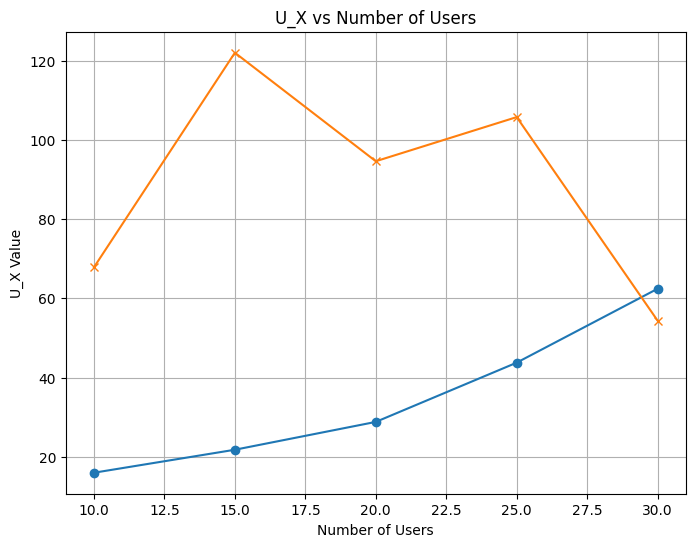

In [7]:
# 读取 JSON 文件中的实验结果
result_paths = [TU_JSON_PATH,EPF_JSON_PATH,BNB_JSON_PATH,RAND_JSON_PATH,ORACLE_JSON_PATH]
markers=['o','x','v','p','s']

plt.figure(figsize=(8,6))
for i,path in enumerate(result_paths):
    with open(path, "r", encoding="utf-8") as f:
        sweep_results = json.load(f)
    # 提取横轴（num_user）和纵轴（U_X）数据
    num_users = []
    U_X = []
    for res in sweep_results:
        # 假设 sweep_param 为 "num_user"，sweep_value 就是用户数量
        num_users.append(res["sweep_value"])
        U_X.append(res["sp_info"]["U_X"])
    # 如果数据无序，可以先排序
    num_users, U_X = zip(*sorted(zip(num_users, U_X), key=lambda x: x[0]))
    # 绘图
    plt.plot(num_users, U_X, marker=markers[i], linestyle="-")

plt.xlabel("Number of Users")
plt.ylabel("$U_E+U_N$")
# plt.title("U_X vs Number of Users")
plt.grid(True)
plt.show()